In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

Завдання №1. Завантанження та клінінг даних

In [62]:
# === pandas ===
data = pd.read_csv("AirQualityUCI.csv", sep=';', decimal=',', header=0)
data = data.iloc[:, :-2] 
data = data[~data.isnull().all(axis=1)]  
data.replace(-200, np.nan, inplace=True) 
data.drop(columns=['NMHC(GT)'], inplace=True)  

df_pandas = data.copy()

start_time = timeit.default_timer()
df_pandas = df_pandas.infer_objects()  
df_pandas.fillna(df_pandas.median(numeric_only=True), inplace=True)
pandas_time = timeit.default_timer() - start_time

# === numpy ===
num = data.select_dtypes(include=[np.number])
arr = num.to_numpy()

start_time = timeit.default_timer()
col_medians = np.nanmedian(arr, axis=0)
inds = np.where(np.isnan(arr)) 
arr[inds] = np.take(col_medians, inds[1]) 
numpy_time = timeit.default_timer() - start_time


non_num = data.select_dtypes(exclude=[np.number]).reset_index(drop=True)
df_numpy = pd.concat([non_num, pd.DataFrame(arr, columns=num.columns)], axis=1)


print(f"=== pandas === заповнення відсутніх значення: {pandas_time:.4f} с")
print(f"=== numpy === заповнення відсутніх значення: {numpy_time:.4f} c")



=== pandas === заповнення відсутніх значення: 0.0078 с
=== numpy === заповнення відсутніх значення: 0.0023 c


In [63]:
df_pandas.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [64]:
df_numpy.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Завдання №2. Нормалізація даних

In [65]:
# === pandas ===
def normalize_pandas(df):
    df_pandas = df.copy()
    num_cols = df_pandas.select_dtypes(include=[np.number]).columns
    
    start_time = timeit.default_timer()
    for col in num_cols:
        min_val = df_pandas[col].min()
        max_val = df_pandas[col].max()
        df_pandas[col] = (df_pandas[col] - min_val) / (max_val - min_val) 
    pandas_time = timeit.default_timer() - start_time
    return df_pandas, pandas_time

df_pandas, pandas_time = normalize_pandas(df_pandas)

# === numpy ===
def normalize_numpy(arr):
    start_time = timeit.default_timer()
    min_val = np.min(arr, axis=0)
    max_val = np.max(arr, axis=0)
    normalized = (arr - min_val) / (max_val - min_val)
    numpy_time = timeit.default_timer() - start_time
    return normalized, numpy_time

arr_numpy, numpy_time = normalize_numpy(arr)

df_numpy_normalized = pd.concat(
    [non_num, pd.DataFrame(arr_numpy, columns=num.columns)],
    axis=1
)

print(f"=== pandas === нормалізація: {pandas_time:.4f} с")
print(f"=== numpy === нормалізація: {numpy_time:.4f} с")


=== pandas === нормалізація: 0.0072 с
=== numpy === нормалізація: 0.0005 с


In [66]:
df_pandas.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066
1,10/03/2004,19.00.00,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,10/03/2004,20.00.00,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,10/03/2004,21.00.00,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,10/03/2004,22.00.00,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216


In [68]:
df_numpy_normalized.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066
1,10/03/2004,19.00.00,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,10/03/2004,20.00.00,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,10/03/2004,21.00.00,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,10/03/2004,22.00.00,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216


Завдання №3. Гістограма по одному із атрибутів та з діапазоном значень

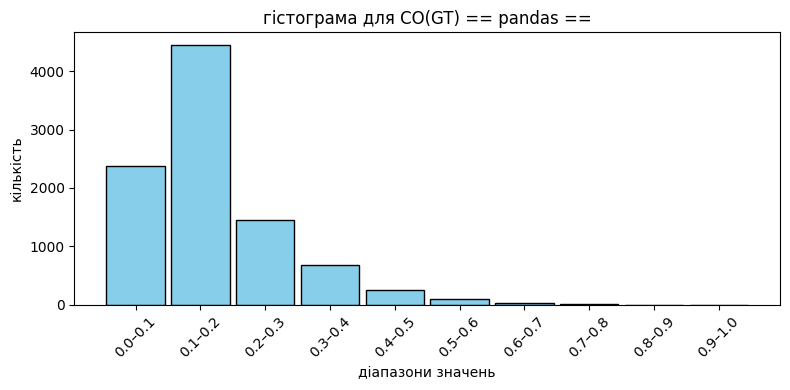

Час виконання: 0.1432 c


In [49]:
def histogram_pandas(df, column, bins):
    data = df[column].dropna()
    counts, bin_edges = np.histogram(data, bins=bins)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(counts)), counts, width=0.9, align='center', color='skyblue', edgecolor='black')
    plt.xticks(range(len(counts)), [f"{round(bin_edges[i], 1)}–{round(bin_edges[i+1], 1)}" for i in range(len(bin_edges)-1)], rotation=45)
    plt.title(f"гістограма для {column} == pandas ==")
    plt.xlabel("діапазони значень")
    plt.ylabel("кількість")
    plt.tight_layout()
    plt.show()

start_time = timeit.default_timer()
histogram_pandas(df_pandas, 'CO(GT)', bins=10)
end_time = timeit.default_timer()

print(f"Час виконання: {end_time - start_time:.4f} c")

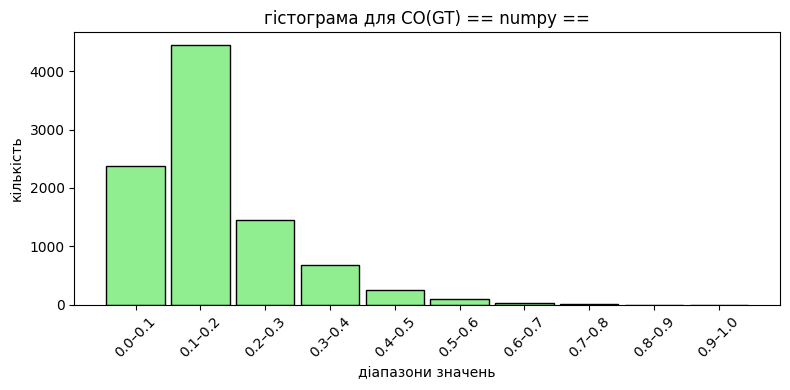

Час виконання: 0.1415 с


In [50]:
def histogram_numpy(arr, column_index, column_name, bins):
    col_data = arr[:, column_index]
    counts, bin_edges = np.histogram(col_data, bins=bins)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(counts)), counts, width=0.9, align='center', color='lightgreen', edgecolor='black')
    plt.xticks(range(len(counts)), [f"{round(bin_edges[i], 1)}–{round(bin_edges[i+1], 1)}" for i in range(len(bin_edges)-1)], rotation=45)
    plt.title(f"гістограма для {column_name} == numpy ==")
    plt.xlabel("діапазони значень")
    plt.ylabel("кількість")
    plt.tight_layout()
    plt.show()


start_time = timeit.default_timer()
co_index = list(num.columns).index('CO(GT)')
histogram_numpy(arr_numpy, co_index, 'CO(GT)', bins=10)
end_time = timeit.default_timer()

print(f"Час виконання: {end_time - start_time:.4f} с")

Завдання №4. Графік залежності одного integer атрибута від іншого.

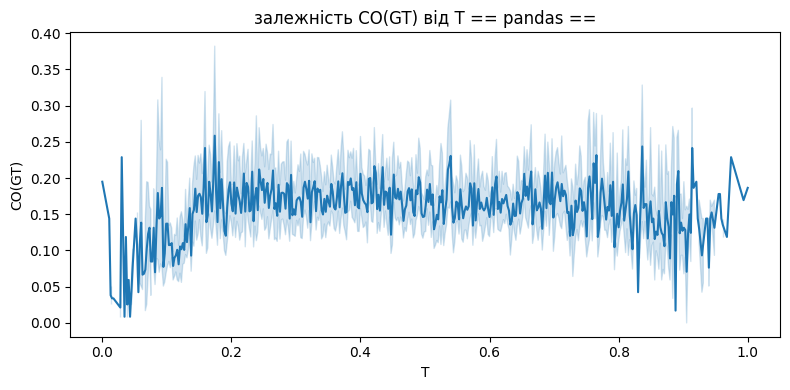

Час виконання: 8.0225 с


In [ ]:
def dependency_pandas(df, x_attr, y_attr):
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x=x_attr, y=y_attr)
    plt.title(f"залежність {y_attr} від {x_attr} == pandas ==")
    plt.xlabel(x_attr)
    plt.ylabel(y_attr)
    plt.tight_layout()
    plt.show()


start_time = timeit.default_timer()
dependency_pandas(df_pandas, 'T', 'CO(GT)')
end_time = timeit.default_timer()

print(f"Час виконання: {end_time - start_time:.4f} с")


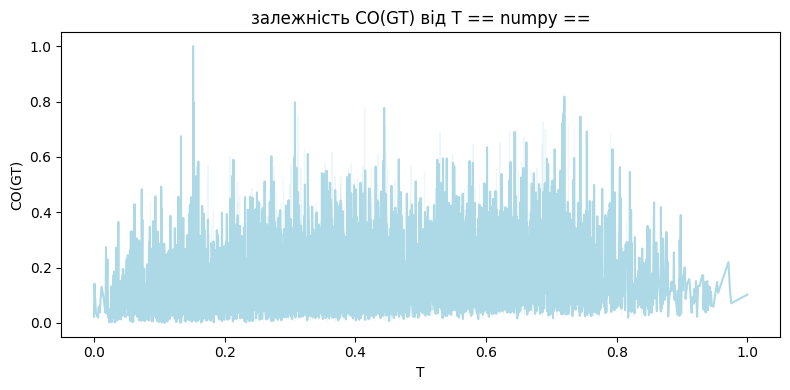

Час виконання: 33.7166 с


In [52]:
def dependency_numpy(arr, x_attr, y_attr, columns):

    x_index = columns.get_loc(x_attr)
    y_index = columns.get_loc(y_attr)
    
    x = arr[:, x_index]
    y = arr[:, y_index]
    

    plt.figure(figsize=(8, 4))
    sns.lineplot(x=x, y=y, color="lightblue")
    plt.title(f"залежність {y_attr} від {x_attr} == numpy ==")
    plt.xlabel(x_attr)
    plt.ylabel(y_attr)         
    plt.tight_layout()
    plt.show()


start_time = timeit.default_timer()
dependency_numpy(arr_numpy, 'T', 'CO(GT)', df_pandas.columns)
end_time = timeit.default_timer()

print(f"Час виконання: {end_time - start_time:.4f} с")

Завдання №5. Підрахунок коефіцієнтів Пірсона та Спірмена для двох integer атрибутів

In [53]:
attr1 = 'T'         
attr2 = 'CO(GT)'    

# == pandas ==
x_df = df_pandas[attr1]
y_df = df_pandas[attr2]

start_time = timeit.default_timer()
pearson_pandas, _ = pearsonr(x_df, y_df)
pearson_pandas_time = timeit.default_timer() - start_time

start_time = timeit.default_timer()
spearman_pandas, _ = spearmanr(x_df, y_df)
spearman_pandas_time = timeit.default_timer() - start_time

print(f"== pandas ==\nПірсон: {pearson_pandas:.4f} (час: {pearson_pandas_time:.6f} c)")
print(f"Спірмен: {spearman_pandas:.4f} (час: {spearman_pandas_time:.6f} c)\n")

# == numpy ==
x_arr = arr_numpy[:, df_pandas.columns.get_loc(attr1)]
y_arr = arr_numpy[:, df_pandas.columns.get_loc(attr2)]

start_time = timeit.default_timer()
pearson_numpy, _ = pearsonr(x_arr, y_arr)
pearson_numpy_time = timeit.default_timer() - start_time

start_time = timeit.default_timer()
spearman_numpy, _ = spearmanr(x_arr, y_arr)
spearman_numpy_time = timeit.default_timer() - start_time

print(f"== numpy ==\nПірсон: {pearson_numpy:.4f} (час: {pearson_numpy_time:.6f} c)")
print(f"Спірмена: {spearman_numpy:.4f} (час: {spearman_numpy_time:.6f} c)")


== pandas ==
Пірсон: 0.0060 (час: 0.001705 c)
Спірмен: 0.0619 (час: 0.001908 c)

== numpy ==
Пірсон: 0.1685 (час: 0.000685 c)
Спірмена: 0.1888 (час: 0.002425 c)


Завдання №6. One Hot Encoding атрибуту Date

In [54]:
cat_attr = 'Date'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# == pandas ==
start_time = timeit.default_timer()
encoded_pandas = encoder.fit_transform(df_pandas[[cat_attr]])
pandas_ohe_time = timeit.default_timer() - start_time

# == numpy ==
cat_column_np = df_pandas[cat_attr].to_numpy().reshape(-1, 1)
start_time = timeit.default_timer()
encoded_numpy = encoder.fit_transform(cat_column_np)
numpy_ohe_time = timeit.default_timer() - start_time

print(f"== pandas == OHE shape: {encoded_pandas.shape}, час: {pandas_ohe_time:.6f} c")
print(f"== numpy == OHE shape:  {encoded_numpy.shape}, час: {numpy_ohe_time:.6f} c")


== pandas == OHE shape: (9357, 391), час: 0.012000 c
== numpy == OHE shape:  (9357, 391), час: 0.009727 c


Завдання №7. Візуалізація багатовимірних даних

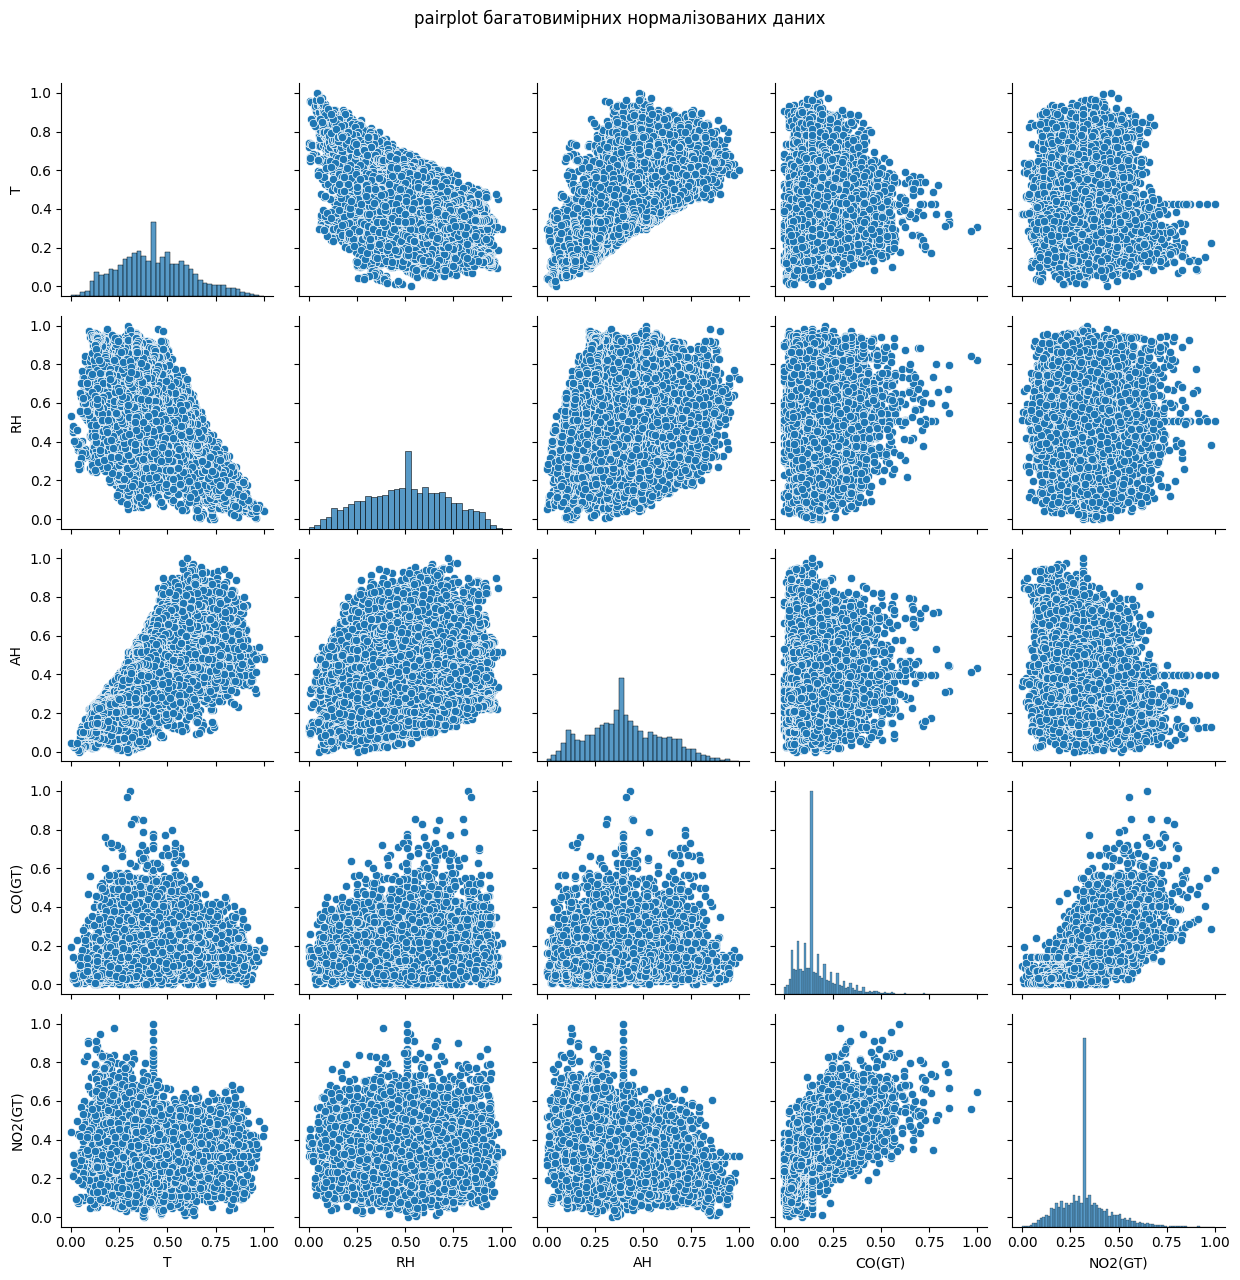

час побудови pairplot: 3.7993 c


In [ ]:
# == pandas ==
num_df = df_pandas.select_dtypes(include=['float64', 'int64'])

start_time = timeit.default_timer()
cols_subset = ['T', 'RH', 'AH', 'CO(GT)', 'NO2(GT)']
sns.pairplot(df_pandas[cols_subset])
plt.suptitle("pairplot багатовимірних нормалізованих даних", y=1.02)
plt.tight_layout()
plt.show()
end_time = timeit.default_timer()

print(f"час побудови pairplot: {end_time - start_time:.4f} c")

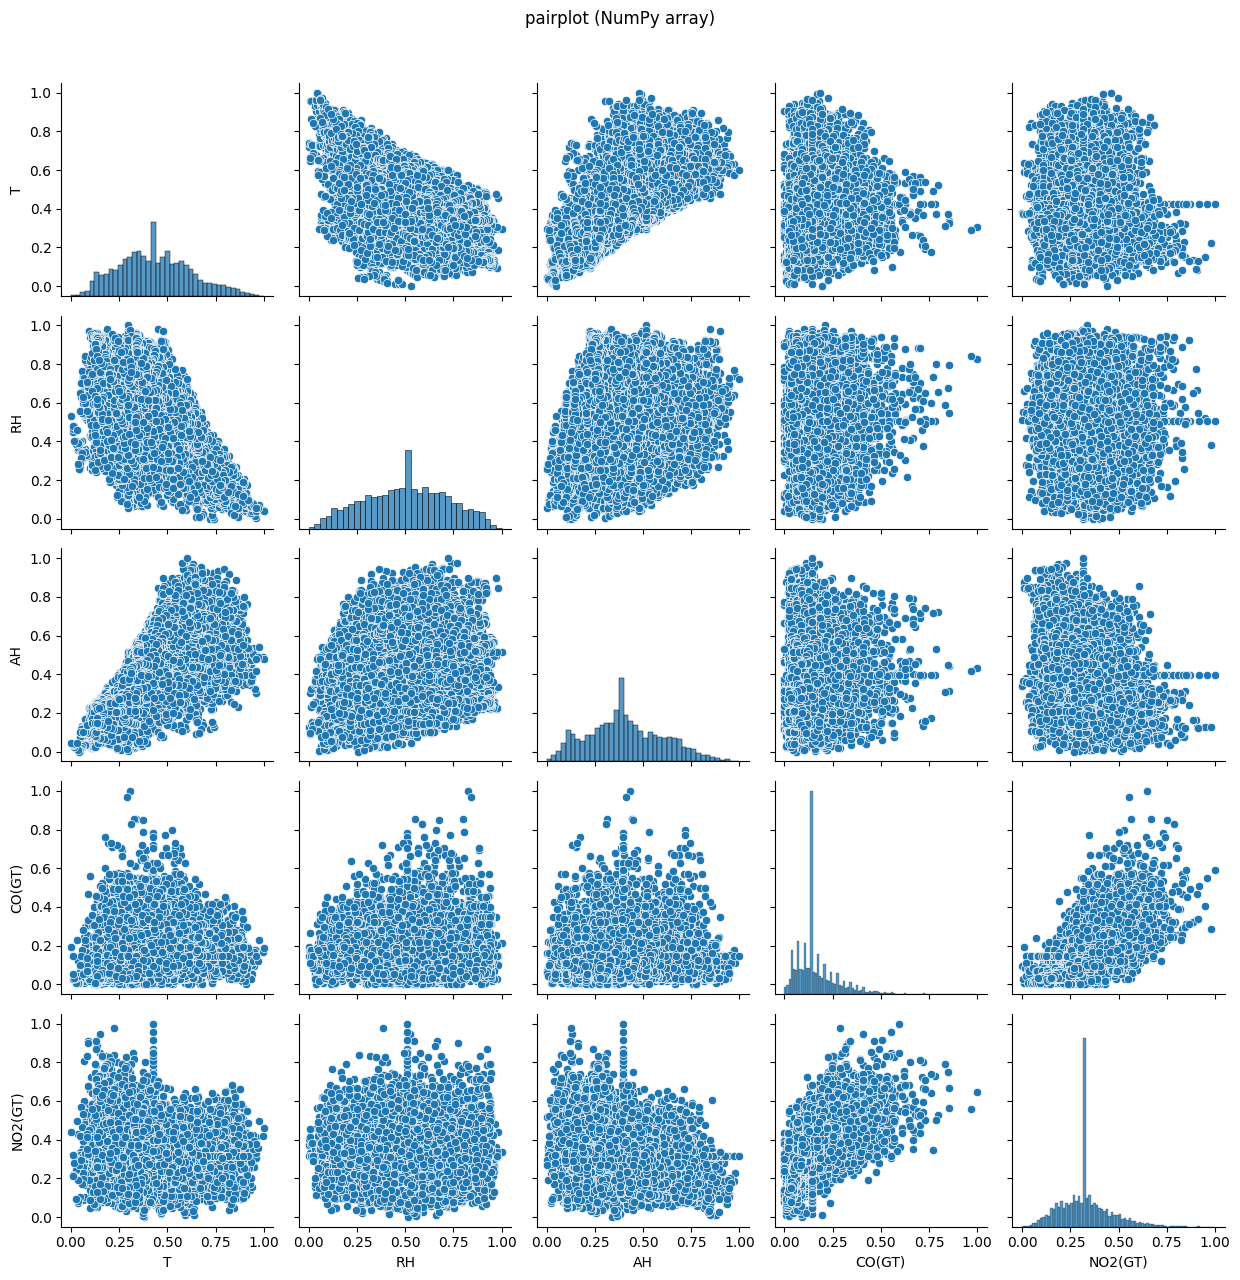

== numpy == час побудови pairplot: 3.6301 c


In [ ]:
# == numpy ==
subset_columns = ['T', 'RH', 'AH', 'CO(GT)', 'NO2(GT)']
start_time_np = timeit.default_timer()
sns.pairplot(df_numpy_normalized[subset_columns])
plt.suptitle("pairplot (NumPy array)", y=1.02)
plt.tight_layout()
plt.show()
end_time_np = timeit.default_timer()
print(f"== numpy == час побудови pairplot: {end_time_np - start_time_np:.4f} c")

Додаткове завдання

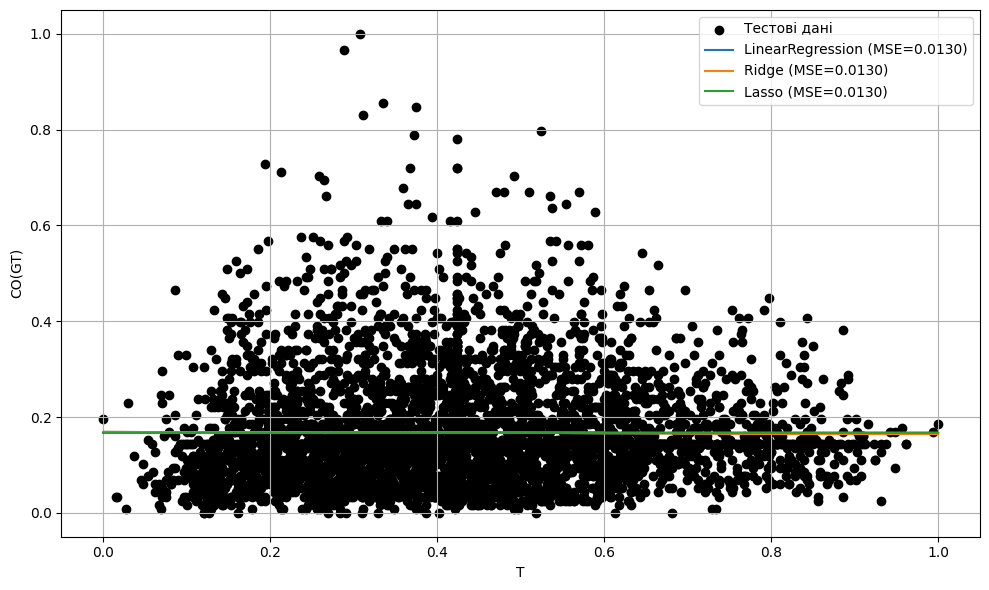

=== pandas === 
MSE для моделей
LinearRegression: 0.0130
Ridge: 0.0130
Lasso: 0.0130
Найкраща модель : Lasso


In [69]:
X_pandas = df_pandas[['T']]
y_pandas = df_pandas['CO(GT)']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pandas, y_pandas, test_size=0.5, random_state=42)


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

mse_scores_pandas = {}

plt.figure(figsize=(10, 6))
plt.scatter(X_test_p, y_test_p, color='black', label='Тестові дані')

for name, model in models.items():
    model.fit(X_train_p, y_train_p)
    y_pred = model.predict(X_test_p)
    mse = mean_squared_error(y_test_p, y_pred)
    mse_scores_pandas[name] = mse
    plt.plot(X_test_p, y_pred, label=f"{name} (MSE={mse:.4f})")

plt.xlabel("T")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("=== pandas === \nMSE для моделей")
for model, score in mse_scores_pandas.items():
    print(f"{model}: {score:.4f}")

best_model_pandas = min(mse_scores_pandas, key=mse_scores_pandas.get)
print(f"Найкраща модель : {best_model_pandas}")


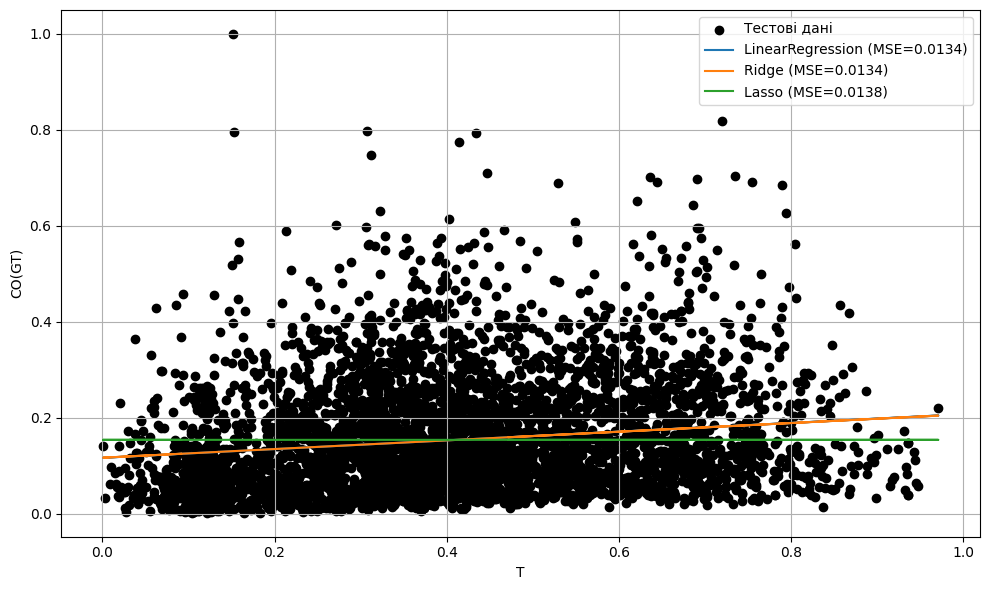

=== numpy === 
MSE для моделей
LinearRegression: 0.0134
Ridge: 0.0134
Lasso: 0.0138
Найкраща модель: LinearRegression


In [70]:
X_numpy = arr_numpy[:, df_pandas.columns.get_loc('T')].reshape(-1, 1)
y_numpy = arr_numpy[:, df_pandas.columns.get_loc('CO(GT)')]

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_numpy, y_numpy, test_size=0.5, random_state=42)


mse_scores_numpy = {}

plt.figure(figsize=(10, 6))
plt.scatter(X_test_n, y_test_n, color='black', label='Тестові дані')

for name, model in models.items():
    model.fit(X_train_n, y_train_n)
    y_pred = model.predict(X_test_n)
    mse = mean_squared_error(y_test_n, y_pred)
    mse_scores_numpy[name] = mse
    plt.plot(X_test_n, y_pred, label=f"{name} (MSE={mse:.4f})")

plt.xlabel("T")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("=== numpy === \nMSE для моделей")
for model, score in mse_scores_numpy.items():
    print(f"{model}: {score:.4f}")

best_model_numpy = min(mse_scores_numpy, key=mse_scores_numpy.get)
print(f"Найкраща модель: {best_model_numpy}")
